In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from gc import callbacks
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import json
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import plot_model
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from time import strftime
import random
import MyLibrary as ml
import pandas as pd
import scipy.io as sio
import sys
print(sys.executable)
print("Tensorflow version: ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2024-06-08 10:25:21.685979: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 10:25:21.689153: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 10:25:22.645544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/ailabguest/anaconda3/envs/py39all/bin/python
Tensorflow version:  2.16.1
Num GPUs Available:  0


2024-06-08 10:25:23.230179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-08 10:25:23.231027: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [34]:
from tensorflow.keras.utils import Sequence
import numpy as np

class DynamicDataGenerator(Sequence):
    def __init__(self, data_paths, dataGroup: dict, window_size, batch_size=32, step_size=1):
        try:
            print("Inizializzazione DynamicDataGenerator...")
            self.data_paths = ml.read_json_file(data_paths)  # Lista dei percorsi ai file dei dati
            self.dataGroupbloccked = dataGroup.copy()
            print("dataGroup:", self.dataGroupbloccked)
            self.dataGroup = self.dataGroupbloccked.copy()
            self.keyattuale, self.canaliAttuali = self.dataGroup.popitem()
            self.canaleAttuale = self.canaliAttuali.pop(0)
            self.ultimafinestra = 0
            #self.indices = self._generate_indices_dinamic()
            self.window_size = window_size
            self.batch_size = batch_size
            self.step_size = step_size
        except Exception as e:
            print("Errore durante l'inizializzazione:", e)
            
    def _generate_indices_dinamic(self):
        indices = []
        json = ml.read_json_file(self.data_paths[self.keyattuale])
        data_length = self._get_data_length(json, self.canaleAttuale)
        if self.canaliAttuali:
            if self.ultimafinestra > data_length:
                self.aggiornaCanale()
        else:
            self.aggiornaKeyCanali()
            
        for _ in range(self.batch_size):
            indices.append((self._get_path(json, self.canaleAttuale), self.ultimafinestra))
            self.ultimafinestra += self.step_size
        return indices
    
    def _get_path(self, json, channel):
        try:
            # Ottieni il percorso del file per la chiave specificata
            return json[channel]["paths"]["assoluto"]
        except KeyError as e:
            print(f"Chiave non trovata nel JSON per il canale {channel}: {e}")
            return None
    
    def _get_data_length(self, json, channel):
        try:
            # Implementa la funzione per ottenere la lunghezza dei dati dal file
            return json[channel]["shape"][0]
        except KeyError as e:
            print(f"Chiave non trovata nel JSON per il canale {channel}: {e}")
            return 0
    
    def _load_data(self, path, start, end):
        try:
            # Implementa la funzione per caricare solo una porzione dei dati
            data = ml.MatToDataFrame(path, key='singleData', IsColpitePath=True)
            datasegment = data[start:end]
            del data
            return datasegment
        except Exception as e:
            print(f"Errore durante il caricamento dei dati da {path} tra {start} e {end}: {e}")
            return None
    
    def __len__(self):
        """
        Calcola il numero di batch per epoca.
        Returns:
            int: Il numero di batch per epoca.
        """
        Dimtot = self.calcolaDimTot()  # Calcola la dimensione totale dei dati
        
        if Dimtot < self.window_size:
            raise ValueError("La dimensione totale dei dati è inferiore alla dimensione della finestra.")
        
        if self.window_size < self.step_size:
            raise ValueError("La dimensione della finestra è più piccola dello step size.")
        
        total_windows = (Dimtot - self.window_size) // (self.step_size + 1)  # Numero totale di finestre possibili
        num_batches = total_windows // self.batch_size  # Numero di batch

        print("Lunghezza:", num_batches)
        return int(num_batches)

    
    def calcolaDimTot(self):
        dim=0
        for key in self.dataGroupbloccked.keys():
            json = ml.read_json_file(self.data_paths[key])
            for canali in list(self.dataGroupbloccked.values()):
                for canale in canali:
                    data_length = self._get_data_length(json, canale)
                    dim=dim+data_length
        return dim
    
    def __getitem__(self, index):
        print("Index:", index)
        # Ottieni gli indici per il batch corrente
        batch_indices = self._generate_indices_dinamic()
        
        # Carica e processa i dati per il batch corrente
        batch = []
        for (path, start) in batch_indices:
            end = start + self.window_size
            data = self._load_data(path, start, end)
            if data is not None:
                # Padding
                if len(data) < self.window_size:
                    padding_needed = self.window_size - len(data)
                    data = np.pad(data, ((0, padding_needed), (0, 0)), 'constant')
                batch.append(data)
        
        # Converti le finestre in array numpy
        batch = np.array(batch)
        
        # Gli autoencoder usano input e output identici
        return batch, batch
    
    def on_epoch_end(self):
        # Reinizializza lo stato del generatore alla fine di ogni epoca
        self.dataGroup = self.dataGroupbloccked.copy()
        
        if not self.dataGroup:
            raise RuntimeError("Il dizionario dei gruppi di dati è vuoto dopo l'inizializzazione.")
        
        self.keyattuale, self.canaliAttuali = self.dataGroup.popitem()
        
        if not self.canaliAttuali:
            raise RuntimeError("La chiave iniziale non ha canali associati.")
        
        self.canaleAttuale = self.canaliAttuali.pop(0)
        self.ultimafinestra = 0

    def aggiornaCanale(self):
        if not self.canaliAttuali:
            raise RuntimeError("Nessun canale rimanente nella lista attuale, aggiornamento della chiave e dei canali.")
        
        self.ultimafinestra = 0
        self.canaleAttuale = self.canaliAttuali.pop(0)

    def aggiornaKeyCanali(self):
        if not self.dataGroup:
            raise RuntimeError("Nessuna chiave rimanente nel dizionario dei gruppi di dati.")
        
        self.ultimafinestra = 0
        self.keyattuale, self.canaliAttuali = self.dataGroup.popitem()
        
        if not self.canaliAttuali:
            raise RuntimeError("La nuova chiave non ha canali associati.")
        
        self.canaleAttuale = self.canaliAttuali.pop(0)


In [35]:
def estrarre_channalli(NummeroDiCanaliPerEsperimento=10):
    nc=NummeroDiCanaliPerEsperimento  
    pathsDastaSet=ml.read_json_file(r"json/NasaDataSetPath.json")
    paths={}
    for path in pathsDastaSet.keys():
        # Estrai tutte le chiavi del dizionario e mescolale
        my_dict=ml.read_json_file(pathsDastaSet[path])
        keys = list(my_dict.keys())
        random.shuffle(keys)

        # Genera un numero casuale minore della lunghezza delle chiavi
        numero_casuale = random.randint(0, len(keys) - 1)

        # Determina l'intervallo per selezionare le chiavi
        if nc % 2 == 0:
            start_index = max(0, numero_casuale - nc//2)
            end_index = min(len(keys), numero_casuale + nc//2)
        else:
            start_index = max(0, numero_casuale - nc//2)
            end_index = min(len(keys), numero_casuale + nc//2 + 1)
        # Verifica se l'intervallo contiene almeno 10 chiavi
        if end_index - start_index < nc:
            # Calcola quanti indici aggiuntivi sono necessari per ottenere 10 chiavi
            indici_aggiuntivi = nc - (end_index - start_index)
            # Se ci sono meno chiavi alla fine, estendi l'intervallo all'inizio
            if len(keys) - end_index < indici_aggiuntivi:
                start_index = max(0, start_index - (indici_aggiuntivi - (len(keys) - end_index)))
            # Altrimenti, estendi l'intervallo alla fine
            else:
                end_index = min(len(keys), end_index + indici_aggiuntivi)

        # Seleziona le chiavi all'interno dell'intervallo
        chiavi_selezionate = keys[start_index:end_index]
        paths[path]=chiavi_selezionate
    return paths


In [2]:
fist=ml.read_json_file(r"json/NasaDataSetPath.json")["B101"]
print(fist)
path=ml.read_json_file(fist)["Channel1"]["paths"]["assoluto"]
print(path)
data = ml.MatToDataFrame(path,key='singleData', IsColpitePath=True)
print(data.shape)
print(len(data))

json/NasaDataSet/B101.json
/media/ailab/RAID0/giovannioliverio/DataSet2/DataSetNasa/B101/B101/Channel1.mat
(12287999, 1)
12287999


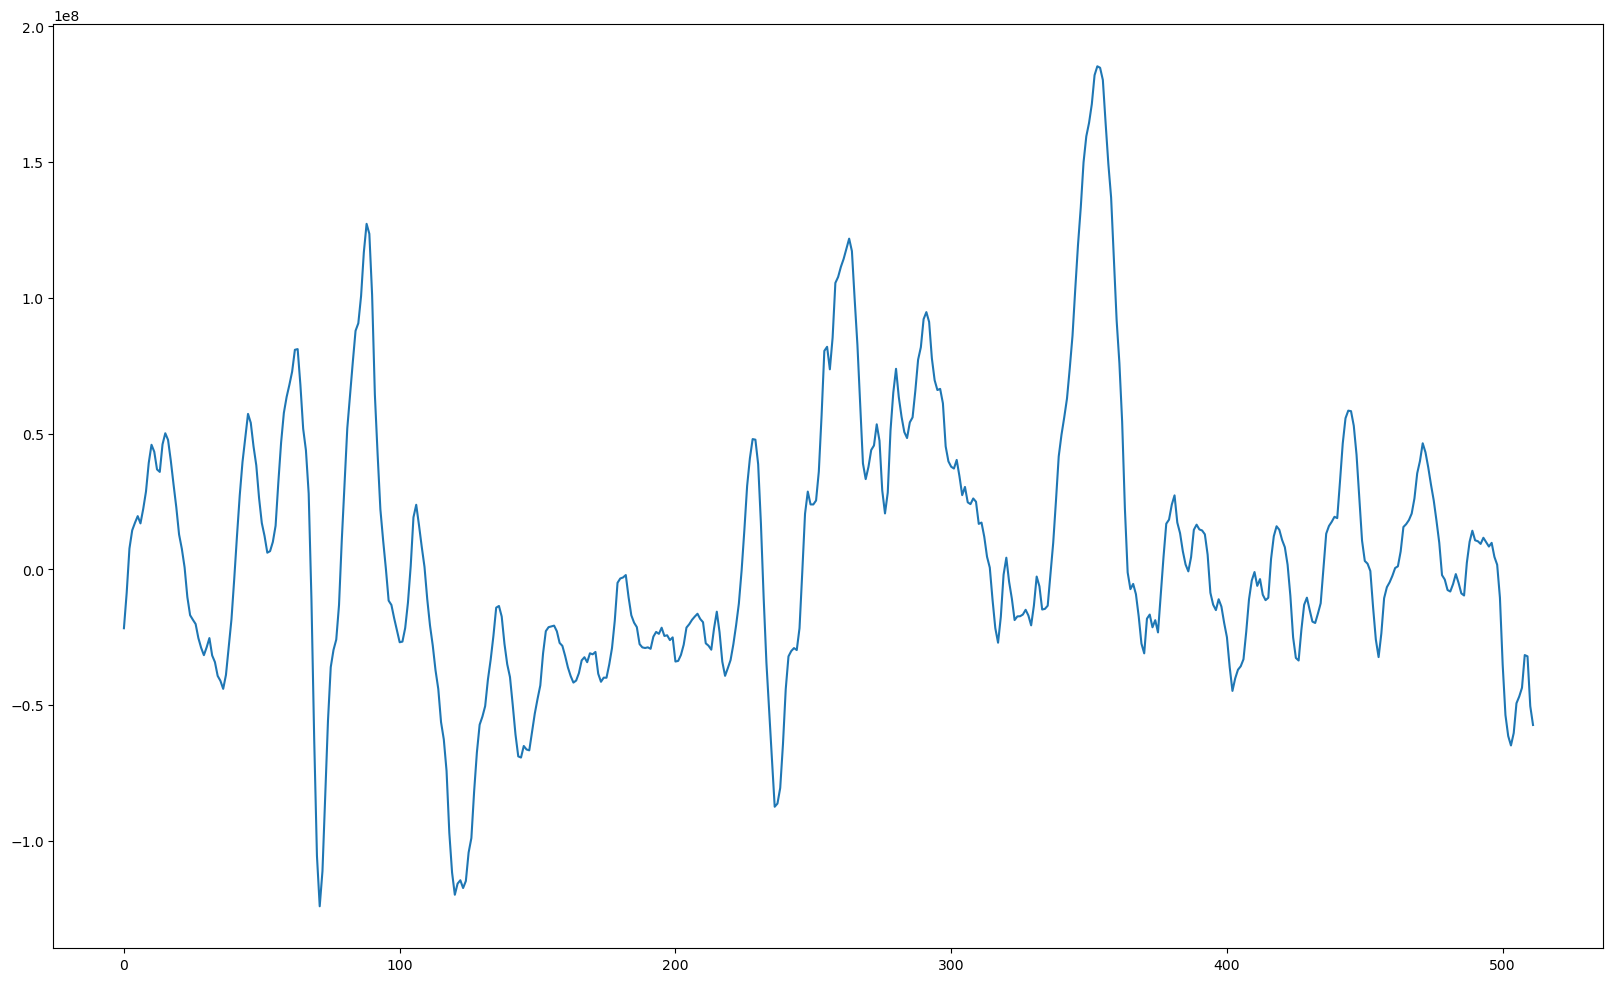

In [37]:

#d.plot()
#data.head()
#print(d)
plt.figure(figsize=(20, 12))
plt.plot(data[:512])

In [3]:
data.rename(columns={0: 'Time-Sequence'}, inplace=True)
data.head(len(data))

,Time-Sequence
0,-21702628.0
1,-8657071.0
2,7671702.0
3,14368814.0
4,17132264.0
...,...
12287994,-31674332.0
12287995,-25849960.0
12287996,-7847381.5
12287997,24490868.0


In [8]:
# Media mobile
data['moving_average'] = data['Time-Sequence'].rolling(window=10).mean()
data['moving_median'] = data['Time-Sequence'].rolling(window=10).median()
data['moving_standard_deviation'] = data['Time-Sequence'].rolling(window=10).std()
data['moving_quantile'] = data['Time-Sequence'].rolling(window=10).quantile(0.25, interpolation='midpoint')
data['moving_max'] = data['Time-Sequence'].rolling(window=10).max()

data.head(len(data))


,Time-Sequence,moving_average,moving_median,moving_standard_deviation,moving_quantile,moving_max,block
0,-21702628.0,NaN,NaN,NaN,NaN,NaN,0
1,-8657071.0,NaN,NaN,NaN,NaN,NaN,0
2,7671702.0,NaN,NaN,NaN,NaN,NaN,0
3,14368814.0,NaN,NaN,NaN,NaN,NaN,0
4,17132264.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...
12287994,-31674332.0,-19001447.00,-16872383.0,7.386440e+06,-21454872.0,-10326027.0,1228799
12287995,-25849960.0,-20553840.30,-17749164.0,6.980731e+06,-25434069.0,-11922771.0,1228799
12287996,-7847381.5,-20146301.35,-17749164.0,7.629426e+06,-25434069.0,-7847381.5,1228799
12287997,24490868.0,-15936538.35,-17014785.0,1.609927e+07,-25434069.0,24490868.0,1228799


In [75]:
# Supponiamo che 'data' sia il tuo DataFrame con la colonna 'Time-Sequence'

# Definisci il numero di punti che vuoi considerare per ogni campione
punti_per_campione = 10

# Calcola il numero totale di nuovi campioni dopo il downsampling
nuovo_numero_campioni = len(data) // punti_per_campione

# Creare un nuovo DataFrame per i dati ridotti
dati_ridotti = pd.DataFrame()

# Calcolare la media dei punti per ogni nuovo campione
dati_ridotti['Time-Sequence'] = data['Time-Sequence'].rolling(punti_per_campione).mean().dropna()

# Visualizza i primi valori del DataFrame dei dati ridotti
dati_ridotti.head(len(dati_ridotti))

,Time-Sequence
9,13545760.30
10,20303308.70
11,25500703.80
12,28413752.00
13,30565153.40
...,...
12287994,-19001447.00
12287995,-20553840.30
12287996,-20146301.35
12287997,-15936538.35


In [80]:
# Seleziona ogni decimo campione
dati_ridotti = data.iloc[::10]

# Visualizza i primi valori del DataFrame dei dati ridotti
dati_ridotti.head(len(dati_ridotti))

,Time-Sequence,moving_average,moving_median,moving_standard_deviation,moving_quantile,moving_max,block
0,-21702628.0,NaN,NaN,NaN,NaN,NaN,0
10,45872856.0,2.030331e+07,1.836189e+07,1.542045e+07,15645051.00,45872856.0,1
20,12815989.0,3.666479e+07,3.840836e+07,1.172435e+07,33548203.00,50117460.0,2
30,-28717958.0,-1.720639e+07,-1.935197e+07,1.307039e+07,-27022057.00,7562576.0,3
40,-3572870.5,-3.050189e+07,-3.294100e+07,1.228653e+07,-39072142.00,-3572870.5,4
...,...,...,...,...,...,...,...
12287950,40557740.0,2.405043e+07,2.537425e+07,1.524100e+07,9371510.25,41512120.0,1228795
12287960,-15229159.0,2.820396e+07,3.610526e+07,2.478020e+07,18523016.50,54709380.0,1228796
12287970,-31490840.0,-3.613484e+07,-3.435614e+07,6.317200e+06,-36795850.00,-27679508.0,1228797
12287980,48777768.0,1.307485e+07,3.978254e+06,2.128294e+07,-1813514.75,48777768.0,1228798


In [72]:

# Supponiamo che 'data' sia il tuo DataFrame con la colonna 'Time-Sequence'

# Definisci il numero di punti che vuoi considerare per ogni campione
punti_per_campione = 10

# Calcola la media di ogni gruppo di punti_per_campione punti temporali
dati_ridotti = data[['Time-Sequence']].rolling(punti_per_campione).mean().iloc[punti_per_campione - 1::punti_per_campione]

# Visualizza i primi valori del DataFrame dei dati ridotti
dati_ridotti.head(len(dati_ridotti))

,Time-Sequence
9,1.354576e+07
19,3.997048e+07
29,-1.305300e+07
39,-3.301640e+07
49,3.449906e+07
...,...
12287949,2.068757e+07
12287959,3.378265e+07
12287969,-3.450868e+07
12287979,5.047986e+06


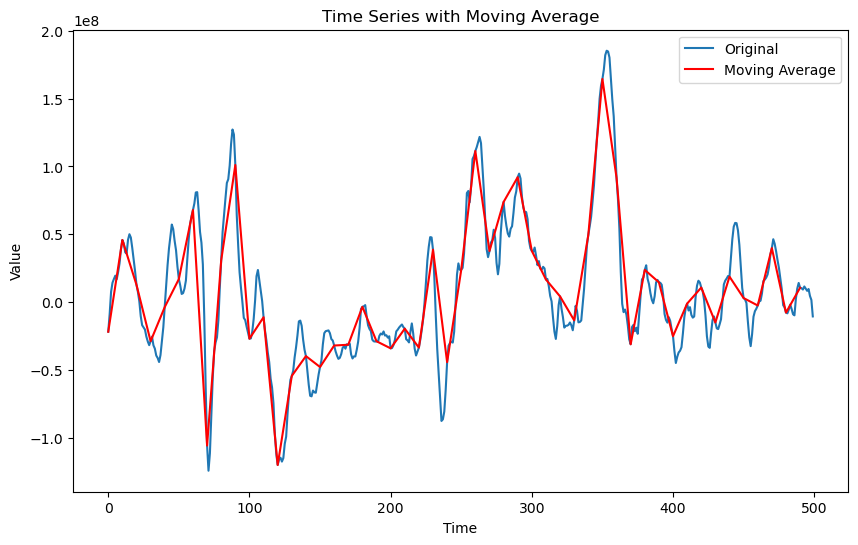

In [81]:

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data['Time-Sequence'][:500], label='Original')
plt.plot(dati_ridotti['Time-Sequence'][:50], label='Moving Average', color='red')
plt.title('Time Series with Moving Average')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [41]:
'''import plotly.express as px
import nbformat
print(nbformat.__version__)

# Creazione del grafico interattivo con Plotly
fig = px.line(data, y='Time-Sequence', title='Interactive Time Series Plot')
fig.show()'''

"import plotly.express as px\nimport nbformat\nprint(nbformat.__version__)\n\n# Creazione del grafico interattivo con Plotly\nfig = px.line(data, y='Time-Sequence', title='Interactive Time Series Plot')\nfig.show()"

/home/ailabguest/anaconda3/envs/py39all/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


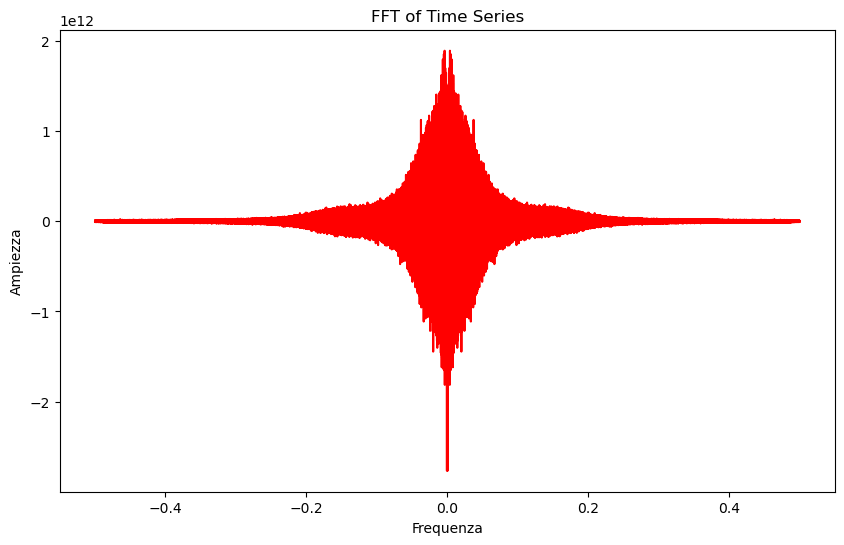

In [42]:
# Trasformata di Fourier
fft = np.fft.fft(data['Time-Sequence'])
fft_freq = np.fft.fftfreq(len(fft))

# Plot dello spettro di frequenza
plt.figure(figsize=(10, 6))
#plt.plot(fft_freq, np.abs(fft))
plt.plot(fft_freq, fft, color='red')
plt.title('FFT of Time Series')
plt.xlabel('Frequenza')
plt.ylabel('Ampiezza')
plt.show()


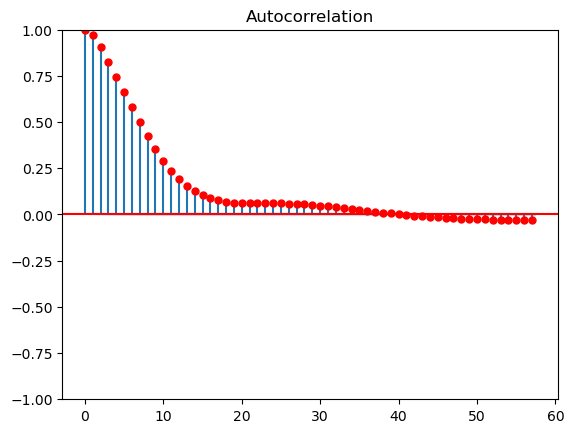

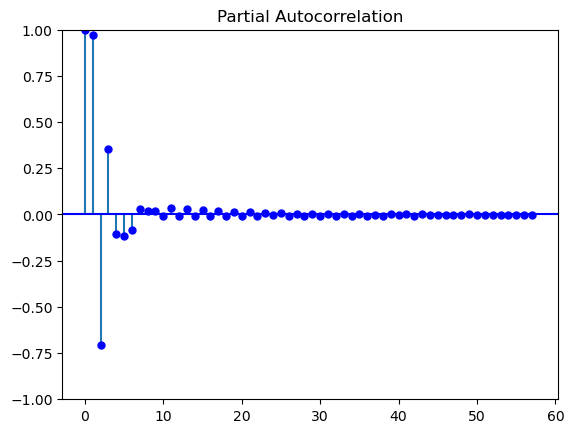

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF e PACF
plot_acf(data['Time-Sequence'][:500000],color='red')
plot_pacf(data['Time-Sequence'][:500000],color='blue')
plt.show()


In [44]:
channalli_estratti=estrarre_channalli(2)
window_size, batch_size, step_size = 512, 32, 512
DynamicDataGenerator=DynamicDataGenerator(r"json/NasaDataSetPath.json",channalli_estratti, window_size, batch_size, step_size)


Inizializzazione DynamicDataGenerator...
dataGroup: {'B101': ['Channel4', 'Channel14'], 'B106': ['Channel48', 'Channel46'], 'B109': ['Channel24', 'Channel6']}


In [45]:
#print(DynamicDataGenerator._generate_indices_dinamic())
print(channalli_estratti)

{'B101': ['Channel4', 'Channel14'], 'B106': ['Channel48', 'Channel46'], 'B109': ['Channel6']}


In [46]:
input_window = Input(shape=(window_size,))
encoder=Sequential([
    Dense(window_size//2, activation='relu'),
    Dense(window_size//4, activation='relu'),
    Dense(window_size//8, activation='relu')
])
encoderWindow = encoder(input_window)
decoder=Sequential([
    Dense(window_size//4, activation='relu'),
    Dense(window_size//2, activation='relu'),
    Dense(window_size, activation='linear'),
])
decoded_window = decoder(encoderWindow)
# Creazione del modello completo dell'autoencoder
autoencoder = Model(inputs=input_window, outputs=decoded_window)
#autoencoder=Sequential([encoderWindow,decoder])

# Stampa della struttura dell'autoencoder
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 64)             │       172,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 512)            │       172,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,408 (1.32 MB)

 Trainable params: 345,408 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.fit(DynamicDataGenerator, epochs=10, verbose=3,shuffle=False)
autoencoder.summary()
autoencoder.save(r"modello_autoencoder.h5")